In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np
import matplotlib

intrinsics = j.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.001, far=1.0
)


model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")

renderer = j.Renderer(intrinsics)
model_names = j.ycb_loader.MODEL_NAMES
for IDX in range(len(model_names)):
    mesh_path_ply = os.path.join(model_dir,"obj_" + "{}".format(IDX+1).rjust(6, '0') + ".ply")
    mesh = j.mesh.load_mesh(mesh_path_ply)
    renderer.add_mesh(mesh, scaling_factor=1.0/1000.0)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [93]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


# TODO
- 2d plot. show ground truth noise level on the heatmap
- vary the pose and see how it changes
- how to visualize full posterior on r and outlier prob

# Observed Image

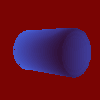

In [110]:
ground_truth_object_id = 3
object_pose = j.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(2),
    j.t3d.transform_from_pos(
        jnp.array([0.0, 0.0, 0.3])
    ),
    0.001, 0.1
)
d = renderer.render_multiobject(
    jnp.array([object_pose]),
    [ground_truth_object_id]
)[:,:,2]

d = j.t3d.unproject_depth(d, intrinsics)
j.get_depth_image(d[:,:,2])

In [114]:
point_cloud = d.reshape(-1,3)
point_cloud = point_cloud[point_cloud[:,2]<intrinsics.far,:]



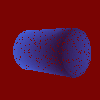

In [171]:
GT_R = 0.0000001

noise = jax.vmap(
    lambda key: jax.random.multivariate_normal(
        key, jnp.zeros(3), jnp.eye(3) * GT_R
    )
)(
    jax.random.split(jax.random.PRNGKey(2), point_cloud.shape[0])
)
point_cloud_noisy = noise + point_cloud
# point_cloud_noisy = point_cloud
# observed_image = point_cloud_noisy.reshape(original_observed_image.shape)
# observed_depth = j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2]
# observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
# observed_image = j.t3d.unproject_depth_jit(observed_depth, intrinsics)
observed_image = j.t3d.unproject_depth(j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2],intrinsics)
observed_image_viz = j.get_depth_image(observed_image[:,:,2])
observed_image_viz

In [172]:
j.meshcat.clear()
j.meshcat.show_cloud("obs", d[:,:,:3].reshape(-1,3))

# Latent Image

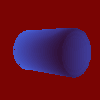

In [173]:
reconstruction = renderer.render_multiobject(
    jnp.array([object_pose]),
    [ground_truth_object_id]
)
reconstruction_seg = reconstruction[:,:,-1]
reconstruction = j.t3d.unproject_depth(reconstruction[:,:,2], intrinsics)
rendered_image_viz = j.get_depth_image(reconstruction[:,:,2])
rendered_image_viz

# Enumerate Posterior over R and Outlier Prob

In [174]:
likelihood_jit = jax.jit(jax.vmap(jax.vmap(j.threedp3_likelihood_multi_r,
       in_axes=(None, None, None, None, 0, None)),
       in_axes=(None, None, None, 0, None, None)),
)

In [175]:
POTENTIAL_R[:,1]

Array([1.e-03, 1.e-04, 1.e-05], dtype=float32)

Text(0, 0.5, 'R')

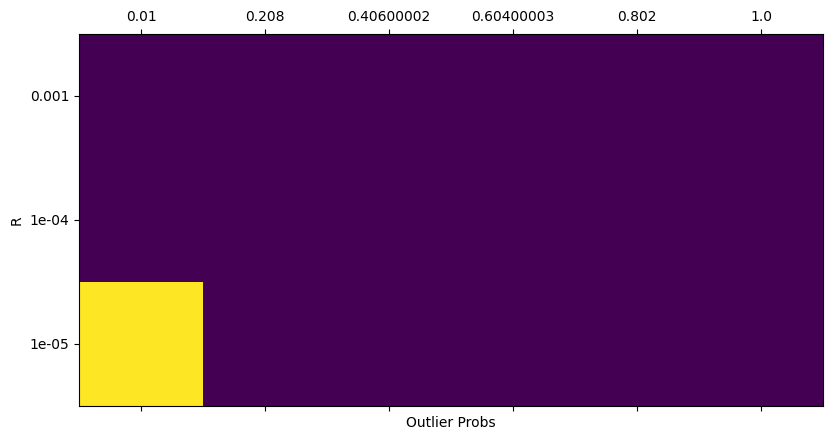

In [176]:
R_SWEEP = jnp.array([0.001, 0.0001, 0.00001]).reshape(-1,1)
R = jnp.ones((R_SWEEP.shape[0],1)) * 0.0001

OUTLIER_PROBS = jnp.linspace(0.01, 1.0, 6)
OUTLIER_VOLUME = 1.0

POTENTIAL_R = jnp.hstack([R,R_SWEEP])
POTENTIAL_R

p = likelihood_jit(
    observed_image,
    reconstruction[:,:,:3],
    reconstruction_seg,
    POTENTIAL_R,
    OUTLIER_PROBS,
    OUTLIER_VOLUME
)
plt.matshow(j.utils.normalize_log_scores(p))
ax = plt.gca()

ax.set_yticks(np.arange(len(POTENTIAL_R[:,1])))
ax.set_yticklabels(POTENTIAL_R[:,1])
ax.set_xticks(np.arange(len(OUTLIER_PROBS)))
ax.set_xticklabels(OUTLIER_PROBS)
ax.set_xlabel("Outlier Probs")
ax.set_ylabel("R")

In [11]:
POTENTIAL_R

NameError: name 'POTENTIAL_R' is not defined

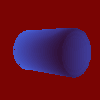

In [9]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


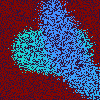

In [165]:

object_pose2 = j.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(2),
    j.t3d.transform_from_pos(
        jnp.array([0.05, 0.0, 0.25])
    ),
    0.001, 0.1
)



original_observed_depth = renderer.render_multiobject(
    jnp.array([object_pose, object_pose2]),
    [GT_ID, 9]
)[...,2]
original_observed_image = j.t3d.unproject_depth(original_observed_depth, intrinsics)

GT_R = 0.00001
point_cloud = original_observed_image.reshape(-1,3)
noise = jax.vmap(
    lambda key: jax.random.multivariate_normal(
        key, jnp.zeros(3), jnp.eye(3) * GT_R
    )
)(
    jax.random.split(jax.random.PRNGKey(2), point_cloud.shape[0])
)
point_cloud_noisy = noise + point_cloud
# point_cloud_noisy = point_cloud
observed_image = point_cloud_noisy.reshape(original_observed_image.shape)
# observed_depth = j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2]
# observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
# observed_image = j.t3d.unproject_depth_jit(observed_depth, intrinsics)
observed_image_viz = j.get_depth_image(j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2])
observed_image_viz

In [166]:
j.meshcat.clear()
j.meshcat.show_cloud("1", observed_image.reshape(-1,3))

In [167]:
ID = GT_ID
# ID = 3
pose_estimate = object_pose

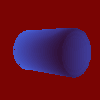

In [168]:
rendered = renderer.render_multiobject(
    jnp.array([pose_estimate]),
    [ID]
)
rendered_depth = rendered[...,2]
rendered_seg = rendered[...,3]
rendered_image = j.t3d.unproject_depth_jit(rendered_depth, intrinsics)
rendered_image_viz = j.get_depth_image(rendered_image[:,:,2],max=intrinsics.far)
rendered_image_viz

In [170]:
likelihood_jit = jax.vmap(jax.vmap(j.threedp3_likelihood,
       in_axes=(None, None, None, None, 0, None)),
       in_axes=(None, None, None, 0, None, None)
)

In [171]:
p = likelihood_jit(observed_image, rendered_image, rendered_seg, R, OUTLIER_PROBS, OUTLIER_VOLUME)

actual R:  1e-05
R:  [1.e-05 1.e-05]  Outlier Prob:  0.2611111


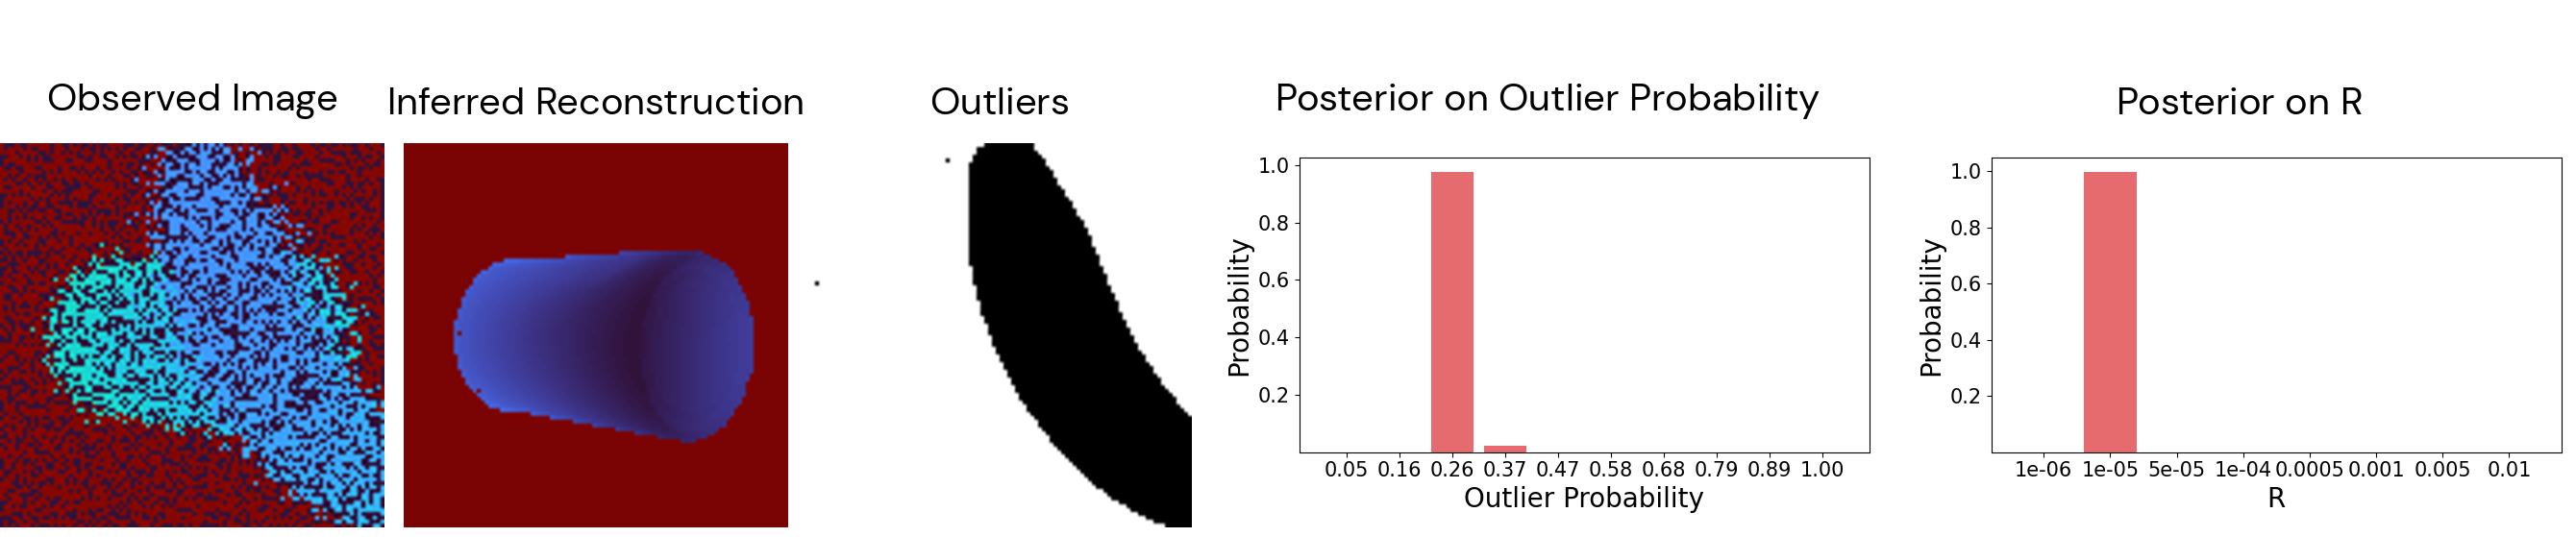

<Figure size 640x480 with 0 Axes>

<Figure size 700x400 with 0 Axes>

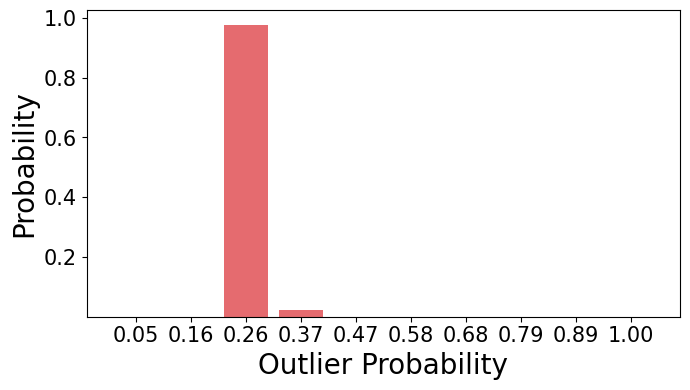

In [172]:
ii,jj = jnp.unravel_index(p.argmax(), p.shape)
best_r, best_outlier_prob = (R[ii], OUTLIER_PROBS[jj])
print("actual R: ", GT_R)
print("R: ", best_r, " Outlier Prob: ", best_outlier_prob)
r_viz = make_r_posterior_graph(R[:,1], j.utils.normalize_log_scores(p).sum(1))
outlier_prob_viz = make_outlier_posterior_graph(OUTLIER_PROBS, j.utils.normalize_log_scores(p).sum(0));

mixture_probs = j.gaussian_mixture_image(observed_image, rendered_image, rendered_seg,best_r)
outliers = (
    mixture_probs * (1.0 - best_outlier_prob) 
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)
outlier_viz = j.get_depth_image(1.0 * outliers, cmap=matplotlib.colormaps['Greys'])

height_factor = outlier_prob_viz.height / observed_image_viz.height
panel = j.multi_panel(
    [
        j.scale_image(observed_image_viz,height_factor),
        j.scale_image(rendered_image_viz,height_factor),
        j.scale_image(outlier_viz,height_factor),
        outlier_prob_viz, r_viz],
    labels=["Observed Image", "Inferred Reconstruction", "Outliers", "Posterior on Outlier Probability", "Posterior on R"],
    label_fontsize=40,
    middle_width = 20
)
panel

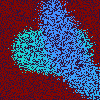

In [173]:
point_cloud = original_observed_image.reshape(-1,3)
noise = jax.vmap(
    lambda key: jax.random.multivariate_normal(
        key, jnp.zeros(3), jnp.eye(3) * best_r[1]
    )
)(
    jax.random.split(jax.random.PRNGKey(2), point_cloud.shape[0])
)
point_cloud_noisy = noise + point_cloud
# point_cloud_noisy = point_cloud
# observed_depth = j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2]
# observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
# observed_image = j.t3d.unproject_depth_jit(observed_depth, intrinsics)
j.get_depth_image(j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2])

In [132]:
outliers.sum()

Array(3302, dtype=int32)